# PSMILES and Weighted Directed Graph Conversions with Deepchem

By Debasish Mohanty

# Table of Contents:
1. [Introduction](#introduction)
2. [Understanding the Conversion Mechanism](#conv-mech)
      - [Weighted Directed Graphs to PSMILES](#wdg2p)
      - [PSMILES to Weighted Directed Graphs](#p2wdg)
3. [Code Implementation with Deepchem](#codeimplement)
      - [Setup](#setup)
      - [WDG to PSMILES](#code-wdg2p)
      - [PSMILES to WDG](#code-p2wdg)
4. [Summary](#sum)
5. [References](#ref)

## 1. Introduction <a id="introduction"></a>

To effectively leverage polymers for informatics tasks using neural networks, it is essential to establish detailed and accurate representation mechanisms for input data. Polymers are inherently complex, and their representations must capture both chemical structure and functional properties. Several polymer representation methods are available, as discussed [in this tutorial](https://deepchem.io/tutorials/an-introduction-to-the-polymers-and-their-representation/). Two key approaches are Polymer Simplified Molecular Input Line Entry System (PSMILES) and Weighted Directed Graphs (WDG), both designed to represent polymers sequentially. For a deeper understanding of WDG, refer to [this tutorial](https://deepchem.io/tutorials/understanding-weighted-directed-graphs-for-polymer-implimentations/).

PSMILES encodes the polymer's structure as a string notation of its building blocks (monomers), while WDGs provide a graph-based representation, capturing both the relative contributions and repetition patterns of these monomers. WDGs convey more intricate details about polymer candidates compared to PSMILES but are more complex to manage computationally. PSMILES, on the other hand, is favored for its simplicity in storage, retrieval, and processing. Given the complementary strengths of these representations, bidirectional conversion between PSMILES and WDGs is critical for enabling diverse analyses, particularly in machine learning-driven studies.

In our paper "Open-source Polymer Generative Pipeline" `[1]`, we employed this conversion mechanism to study representational variation across different discrimination algorithms. This tutorial provides an overview of the conversion process between PSMILES and WDGs, emphasizing their functional significance in polymer informatics.

## 2. Understanding the Conversion Mechanism <a id="conv-mech"></a>

The PSMILES representation specifies the terminal point where the next monomer unit can be appended, whereas the Weighted Directed Graph (WDG) representation captures the connections between repeating units, including their proportional contributions and the weight assigned to each bond at the end of the string representation. Consequently, PSMILES can be considered as a subset of the information encoded in WDGs. The conversion between these two representations is inherently interconnected, involving the addition or omission of certain technical details. In the subsequent sections, we will delve into the specifics of this conversion mechanism. The weighted directed graphs representations are utilizied previously for property prediction tasks, specifically with weighted-Directed Message Passing Neural Network (w-DMPNN). `[2]`

### Weighted Directed Graphs to PSMILES <a id="wdg2p"></a>

The conversion mechanism of the weighted directed graphs to PSMILES is comparatively simpler. We must omit the monomer proportional contribution and the bond weight mapping data and restructure the rest of the chemical descriptions to get the PSMILES string. As some of the important data is removed in this process, we are required to keep the additional data as metadata to ensure exact reproducibility. The conversion process of WDG to PSMILES will go through the following processes to complete.

1. The WDG string will be split into three sections (i.e. pre, mid, and tail)
2. The pre section containing the component details will go through the following steps to keep the bond details for reproducibility
    - The SMART notation of the bonds is converted into simple wildcards (`*`)
    - The molecules are collected by splitting from ".".
    - The resultant strings will be valid SMILES, which can undergo molecular operations using RDKit `[4]`.
    - Using RDKit valid bonds are formed between two of the wildcard-containing molecules.
    - The wildcard bond with consecutive atom index is removed to emulate the process of valid unit monomer generation.
    - That specific atom index and the SMILES string indices are saved as metadata (with key `indicies` and `seq_index` respectively)
    - The resultant string formation will be a valid PSMILES.
3. The mid and tail sections is joined as a string to be kept as a metadata with key `residue`.

Let's see the process with an example.

Example WDG string -> `[*:1]CC[*:2].[*:3]CC[*:4]|0.5|0.5|<1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5`

- Splitting the parts ->

    Pre: `[*:1]CC[*:2].[*:3]CC[*:4]`
    Mid: `|0.5|0.5|`
    Tail: `<1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5`

- Converting to simple wildcard -> 

    `[*:1]CC[*:2].[*:3]CC[*:4]` --> `*CC*.*CC*`

- Getting RDKit molecule objects and getting the wildcard indices from the molecule and deleting substructures of `*`->

    `*CC*.*CC*` : Mol 1 -> `*CC*` Mol 2 -> `*CC*`

- Bonding at index 3 and 4 and deleting substructures from `*` ->

    Mol -> `*CC**CC*` metadata["indicies"] -> [3, 4]

- Remove the consecutive `**` for a valid string representation of PSMILES -> 

    Mol -> `*CCCC*` metadata["seq_index"] -> 3

- Forming the residue ->

    metadata["residue"] -> Mid + Tail ->  `|0.5|0.5|<1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5`

- Final Output ->

    PSMILES -> `*CCCC*`

    Metadata -> `{
    "indicies": [3, 4],
    "seq_index": 3,
    "residue": "|0.5|0.5|<1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5"
    }`

These processes are handled by DeepChem's `WDG2PSMILESConverter` class to give you the converted format with ease. The code implementation of the same can be found in the following sections.


### PSMILES to Weighted Directed Graphs <a id="p2wdg"></a>

The PSMILES string contains the sequential string notation like SMILES with the inclusion of wildcard notation like `*` or `[*]`. A similar notation can be found in the weighted directed graphs with an additional integer index for the open bond. The PSMILES usually contains a reference of a single repeating unit, while the WDG contains two repeating units indicating their bond connection between two units with digits. Those digits are again used in the tail section of the WDG string representation to map a weight value as a floating point. Hence to convert the PSMILES to WDG we can have the following steps.

1. Convert the PSMILES string into Two Sections
    - By splitting the PSMILES at a given bond index (if there is metadata for the conversion)
    - By repeating twice the unit component (if there is no metadata or it's a homo-polymer)

2. Assign the indices to the bonds for SMILES Arbitrary Target Specification (SMARTS) like notation at the wildcard (`*`).
3. Conditionally assign the mid and tail sections of the WDG
    - If there is metadata, it will contain these sections as a residue text
    - If there is no metadata.
        - We can assume the repeating proportion to be equal of 0.5 and 0.5 (for homo-polymers) and compose the mid-section of the string accordingly.
        - we can consider the repeating pattern to be "alternating", "random" or "block". Based on this, we will assign the tail bond weight sections for two repeating sections.
4. Join the string section with SMARTS indices, the mid and the tail section to get the whole WDG representation.

Let us see these processes with an example:

**Case: 1 (Considering there is no metadata)**

Example PSMILES string -> `*CC*`

- Converting PSMILES to multiple forms

    Resultant Presentation -> `*CC*.*CC**`

- Assigning indices for the wildcards

    Resultant Presentation -> `[*:1]CC[*:2].[*:3]CC[*:4]`

- Assigning mid part considering it's a homo-polymer (one type of repeating unit)

    Mid Part -> `|0.5|0.5|`

- Assigning tail part for different cases
    - For alternate -> `<1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5`
    - For block -> `<1-2:0.75:0.75<3-4:0.75:0.75<1-3:0.125:0.125<1-4:0.125:0.125<2-3:0.125:0.125<2-4:0.125:0.125`
    - For random -> `<1-2:0.50:0.50<3-4:0.50:0.50<1-3:0.33:0.33<1-4:0.33:0.33<2-3:0.33:0.33<2-4:0.33:0.33`

*Note - For a better understanding of the above weight sequences for bond indices refer to the research paper "A graph representation of molecular ensembles for polymer property prediction". `[2]`*

- Joining all the parts to get the string representation of weighted directed graphs

    - WDG Representation (for alternate): `[*:1]CC[*:2].[*:3]CC[*:4]|0.5|0.5|<1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5`
    - WDG Representation (for block): `[*:1]CC[*:2].[*:3]CC[*:4]|0.5|0.5|<1-2:0.75:0.75<3-4:0.75:0.75<1-3:0.125:0.125<1-4:0.125:0.125<2-3:0.125:0.125<2-4:0.125:0.125`
    - WDG Representation (for random): `[*:1]CC[*:2].[*:3]CC[*:4]|0.5|0.5|<1-2:0.50:0.50<3-4:0.50:0.50<1-3:0.33:0.33<1-4:0.33:0.33<2-3:0.33:0.33<2-4:0.33:0.33`

**Case: 2 (Considering there is metadata)**

Example PSMILES string -> `*CCCC*`

Example Metadata -> `{
    "indicies": [3, 4],
    "seq_index": 3,
    "residue": "|0.5|0.5|<1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5"
    }`

- Converting the PSMILES into 2 sections
    - Placing multi-wild card `**` at `seq_index` place of the PSMILES
        Resultant Representation -> `*CC**CC`

    - Adding fragmentation at atom indicies from the metadata
        Resultant Representation -> `*CC*.*CC*`

- Adding indices to the string representation
    Resultant Representation -> `[*:1]CC[*:2].[*:3]CC[*:4]`

- Adding the residue text at the end to get the final WDG Representation
    Resultant Representation -> `[*:1]CC[*:2].[*:3]CC[*:4]|0.5|0.5|<1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5`


*Note - With metadata a precise WDG can be restored and without it, 3 variations of WDGs can be formed consisting of Random, Alternate, and Block repetition arrangment.*

These processes are handled by DeepChem's `PSMILES2WDGConverter` class to give you the converted format with ease. The code implementation of the same can be found in the following sections. 


## 3. Code Implementation with Deepchem <a id="codeimplement"></a>



### Setup <a id="setup"></a>

In [ ]:
# installation
! pip install rdkit deepchem networkx

In [9]:
# all imports
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from matplotlib import pyplot as plt
import networkx as nx
import re
from deepchem.utils.poly_converters import PSMILES2WDGConverter, WDG2PSMILESConverter

#### Visualization Setup

In [5]:
# utils functions for visualization

# for PSMILES

def show_mols(mols: list, labels: list, figsize=(10,10)):
    """
    This function is used to display a list of molecules using matplotlib.
    """
    if len(mols) > 1: 
        fig, ax = plt.subplots(1, len(mols), figsize=figsize)
        for i in range(len(mols)):
            mol = mols[i]
            label = labels[i]
            img = Draw.MolToImage(mol)
            ax[i].imshow(img)
            ax[i].set_title(label)
            ax[i].axis('off')
            ax[i].set_aspect('equal')
    else:
        mol = mols[0]
        label = labels[0]
        img = Draw.MolToImage(mol)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.show()

In [10]:
# for weighted directed graphs

def rev_bonds(bond_str):
  """creates reverse bonds of the existing bonds between open bonds"""
  rev_str = str(bond_str.split("-")[-1])+"-"+str(bond_str.split("-")[0])
  return rev_str

# creating colour mapping for different atoms
COLOR_MAPPER ={
    "C" : "green",
    "F" : "blue" ,
    "O" : "yellow"
}


def smiles_to_graph(smiles_string):
    """Converts a SMILES string to a weighted, directed NetworkX graph."""

    # >>> Parsing the string values to different segments

    # Split the SMILES string by the pipe (|) delimiter
    parts = smiles_string.split('|')
    node_colors = []

    # Extract the SMILES representation of monomers (before the pipe)
    monomer_smiles = parts[0]

    # Extracting connection bond details from string representation
    bonds_strs= parts[-1].split("<")[1:]

    # >>> Structuring the input properly 

    # creating dictionary of bonds in both directions
    bond_dict={ k.split(":")[0]: k.split(":")[1] for k in bonds_strs }
    rev_bond_dict={ rev_bonds(bond_val):bond_wei for (bond_val,bond_wei) in bond_dict.items() }
    bond_dict.update(rev_bond_dict)

    node_labels = {}

    # >>> Handling graph generation and weight assignment 

    # Create an empty directed graph
    G = nx.DiGraph()

    # Process the monomer SMILES string using RDKit
    mol = Chem.MolFromSmiles(monomer_smiles)
    atoms = mol.GetAtoms()

    updater = 1

    # Add nodes to the graph based on atom indices
    for atom in atoms:
      if (atom.GetSymbol() == "*"):
        # adding wild card atoms and assigning labels with it
        G.add_node(atom.GetIdx())
        node_labels[atom.GetIdx()] = f"*{updater}"
        node_colors.append("gray")
        updater += 1
      else:
        G.add_node(atom.GetIdx())
        node_labels[atom.GetIdx()] = f"{atom.GetSymbol()}"
        node_colors.append(COLOR_MAPPER[f"{atom.GetSymbol()}"])



    # Process edges (bonds) and weights
    for bond in mol.GetBonds():
        source = bond.GetBeginAtomIdx()
        target = bond.GetEndAtomIdx()
        G.add_edge(source, target, weight=1.0, label="1.0")
        G.add_edge(target, source, weight=1.0, label="1.0")

    # assigning new connected edges to the graph
    for bond_val, wei_val in bond_dict.items():
      start = "*"+bond_val.split("-")[0]
      end = "*"+bond_val.split("-")[1]
      start_idx, end_idx = None,None
      for idx,val in node_labels.items():
        if val == start:
          start_idx = idx
        elif val == end:
          end_idx = idx
      # handling self edge case
      if start == end and start != None:
        G.add_edge(start_idx,start_idx, weight=wei_val, label=f"{wei_val}")
      else:
        if start_idx == None: raise ValueError(f"Index not found for start wildcard {start}")
        if end_idx == None: raise ValueError(f"Index not found for end wildcard {end}")
        G.add_edge(start_idx,end_idx, weight=wei_val, label=f"{wei_val}")


    return G, node_labels, node_colors

def draw_graph(smiles_string, figsize=(8,8)):
  """This function draws the graph with edge-labels and colors"""
  G, node_labels, node_colors  = smiles_to_graph(smiles_string)

  plt.figure(figsize=figsize)
  # Create visual representation using Matplotlib and NetworkX
  pos = nx.spring_layout(G)  # Use a layout algorithm
  # node_labels = {node: node for node in G.nodes()}

  # Customize edge labels to display weights
  edge_labels = {(source, target): data['label'] for source, target, data in G.edges.data()}

  nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_shape='o')
  nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrows=True, width=2, alpha=0.7, edge_color="black")
  nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12)
  nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

  plt.axis('off')
  plt.show()

def convert_format(text):
  """This function is used to convert the format of the string from [*:x] to [x*] 
  to emulate the conversion from SMARTS to a modified SMARTS format
  (as the visualization setup uses this format)"""
  return re.sub(r'\[\*\:(\d+)\]', r'[\1*]', text)

### WDG to PSMILES <a id="code-wdg2p"></a>

We will implement the conversion mechanism with example of Poly-ethylene using following set of codes.

In [11]:

# weighted directed graph of poly-ethylene (polythylene is a homopolymer hence it's a single monomer repeated [emulates only alternate arrangement])
wd_graph_string = "[*:1]CC[*:2].[*:3]CC[*:4]|0.75|0.25|<1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5"

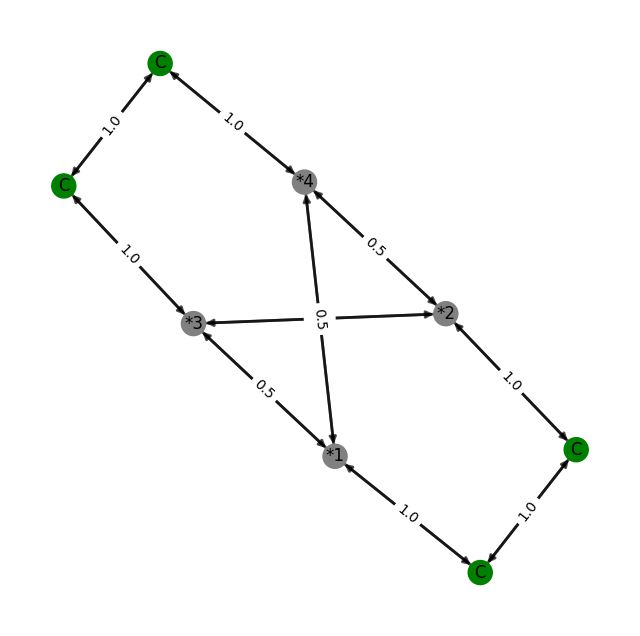

In [ ]:
# visualizing the weighted directed graph
draw_graph(convert_format(wd_graph_string))

Let's convert the above weighted directed graph into corresponding PSMILES format.

In [ ]:
converter = WDG3PSMILESConverter(return_metadata = True)

In [14]:
result, meta = converter([wd_graph_string])

In [15]:
print("result >>", result)
print("meta >>", meta)

result >> ['*CCCC*']
meta >> [{'indicies': [3, 4], 'seq_index': 3, 'residue': '0.75|0.25|<1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5', 'smiles_type': 'SMARTS'}]


As discussed in the conversion mechanism section the above result and metadata is recieved. 

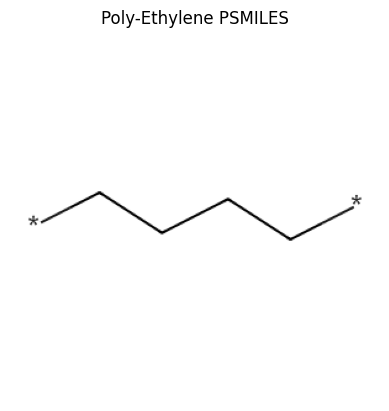

In [17]:
mol = Chem.MolFromSmiles(result[0])
show_mols([mol], ["Poly-Ethylene PSMILES"])

In the above manner, we can build PSMILES along with the metadata from weighted directed graphs.

### PSMILES to WDG <a id="code-p2wdg"></a>

As we discussed in the conversion mechanism section, there are two ways for converting PSMILES to WDG (i.e. with or without metadata).

Let's code considering conversion the case of PSMILES without metadata !

In [19]:
psmiles_to_wdg_converter = PSMILES2WDGConverter()

From the last section we got the PSMILES as result -> `*CCCC*`

We can use that result with the following code.

In [20]:
psmiles_res = psmiles_to_wdg_converter(result)

In [21]:
print(psmiles_res)

[['[1*]CCCC[2*].[3*]CCCC[4*]|0.5|0.5|<1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5']]


The converter builds the WDG considering it's an alternate copolymer specifically if any metadata or repetitiion pattern is not mentioned. This conversion takes place by mupltiplying the unit PSMILES twice and assigning weights accordingly. Let's visualize the WDG build from this specific process.

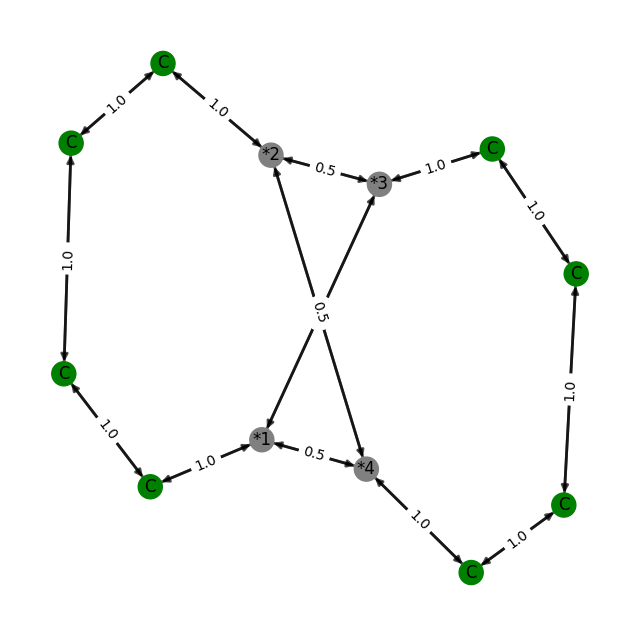

In [23]:
draw_graph(convert_format(psmiles_res[0][0]))

As conversion of PSMILES to WDG can be done in one to many approach. We can also generate random and block polymer WDGs using the converter in following fashion. 

In [24]:
psmiles_to_wdg_converter = PSMILES2WDGConverter(conversion_types=["alternate", "block", "random"])

In [27]:
wdg_res_multi = psmiles_to_wdg_converter(result)

In [28]:
print(wdg_res_multi)

[['[1*]CCCC[2*].[3*]CCCC[4*]|0.5|0.5|<1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5', '[1*]CCCC[2*].[3*]CCCC[4*]|0.5|0.5|<1-2:0.75:0.75<3-4:0.75:0.75<1-3:0.125:0.125<1-4:0.125:0.125<2-3:0.125:0.125<2-4:0.125:0.125', '[1*]CCCC[2*].[3*]CCCC[4*]|0.5|0.5|<1-2:0.50:0.50<3-4:0.50:0.50<1-3:0.33:0.33<1-4:0.33:0.33<2-3:0.33:0.33<2-4:0.33:0.33']]


From the above output we can observe three variations of the PSMILES according to the repetition pattern mentioned during initialization.

Let's visualize the variations !

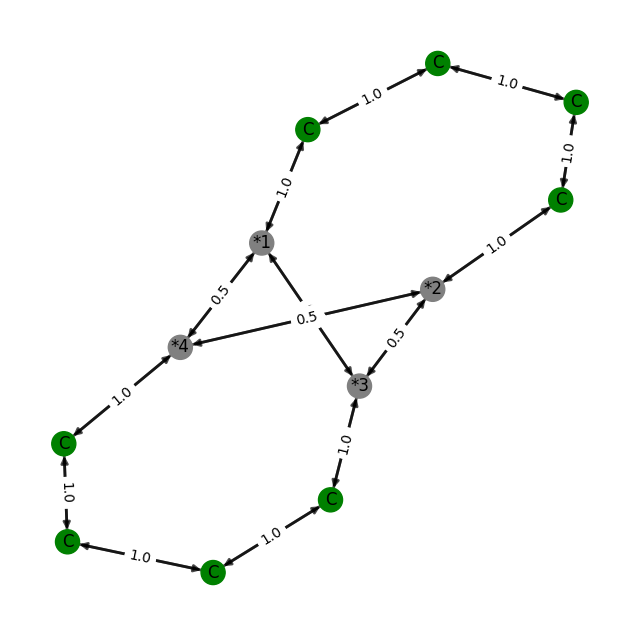

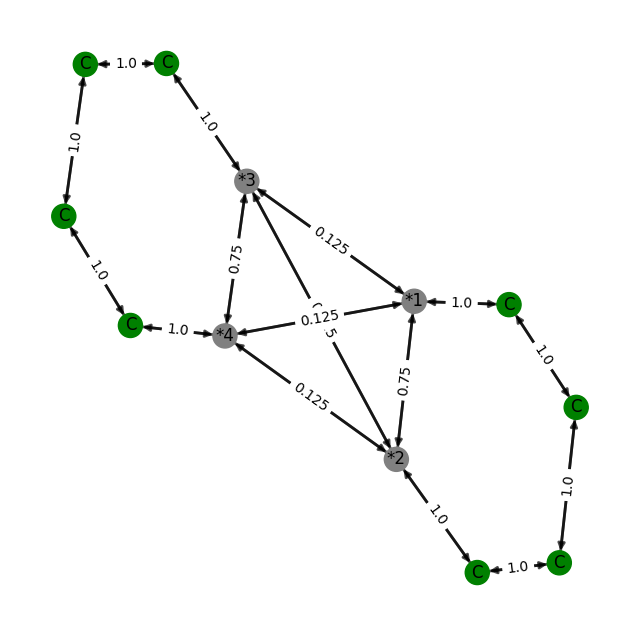

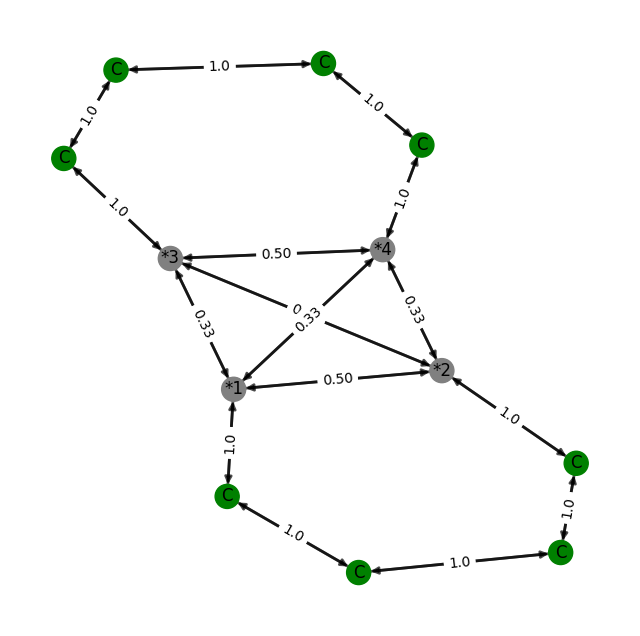

In [29]:
for wdgs in wdg_res_multi[0]:
    draw_graph(convert_format(wdgs))

In this manner we can convert the PSMILES into multiple WDG formats if metadata is not provided.

If we are provided a valid metadata we can compose the exact WDG from the PSMILES using following code format.

Let's reproduce the weighted graph of Poly-ethylene we converted to PSMILES using the same result and metadata in previous section.

In [32]:
wdg_res_w_meta = psmiles_to_wdg_converter(result, meta)

In [33]:
print(wdg_res_w_meta)

[['[*:1]CC[*:2].[*:3]CC[*:4]|0.75|0.25|<1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5']]


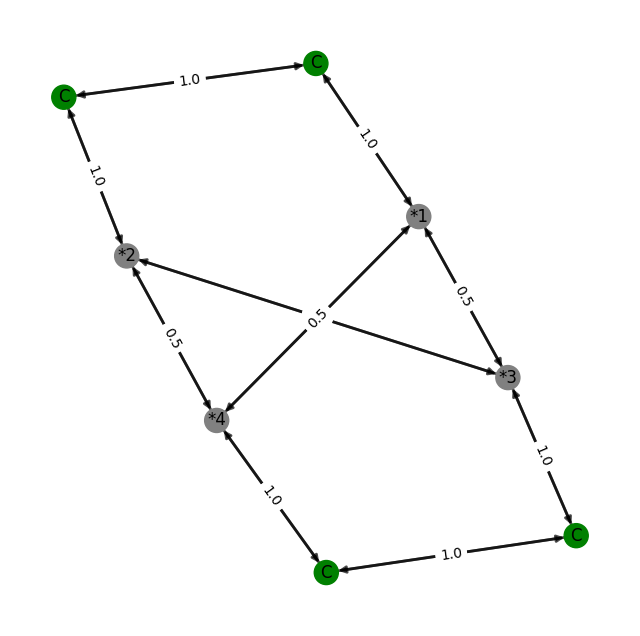

In [34]:
draw_graph(convert_format(wdg_res_w_meta[0][0]))

As visualized in the above output, we can confirm that exact WDG is achieved using the PSMILES and metadata. In this manner PSMILES can be converted to WDG and viceversa using DeepChem's funtionalities.

## 4. Summary <a id="sum"></a>

Polymers require detailed and accurate representations for informatics tasks. Two key representations, Polymer Simplified Molecular Input Line Entry System (PSMILES) and Weighted Directed Graphs (WDGs), are crucial for capturing both the chemical structure and functional properties of polymers. PSMILES offers a simpler string-based notation, while WDGs provide a graph-based approach with more complex details. This tutorial discusses bidirectional conversion between these two formats, which is important for machine learning applications.

- **Weighted Directed Graphs to PSMILES**: The conversion from WDG to PSMILES involves simplifying the WDG representation by removing bond weight and monomer contribution data. The WDG string is split into pre, mid, and tail sections, and the pre section is processed by converting bonds to wildcards, creating RDKit molecule objects, and saving metadata. The class `WDG2PSMILESConverter` from Deepchem handles this conversion.

- **PSMILES to Weighted Directed Graphs**: Converting PSMILES back to WDGs involves creating repeating units from the PSMILES string and assigning indices to bond locations. The mid and tail sections of the WDG can either come from stored metadata or be generated based on assumptions like equal proportions or patterns such as "alternating," "random," or "block." This conversion process is more intricate due to the need for reconstructing bond weights and patterns. The class `PSMILES2WDGConverter` from Deepchem handles this conversion.

## 5. Reference <a id="ref"></a>

1. [Mohanty, Debasish, et al. "Open-source Polymer Generative Pipeline." arXiv preprint arXiv:2412.08658 (2024).](https://arxiv.org/abs/2412.08658)
2. [Aldeghi, Matteo, and Connor W. Coley. "A graph representation of molecular ensembles for polymer property prediction." Chemical Science 13.35 (2022): 10486-10498.](https://pubs.rsc.org/en/content/articlehtml/2022/sc/d2sc02839e)
3. [Daylight Chemical Information Systems, Inc. "SMARTS-A Language for Describing Molecular Patterns." 120 Vantis–Suite 550–Aliso Viejo, CA 92656 (2007).](https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html)
4. [Landrum, Greg. "Rdkit documentation." Release 1.1-79 (2013): 4.](https://readthedocs.org/projects/rdkit/downloads/pdf/latest/)

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!

## Join the DeepChem Discord
The DeepChem [Discord](https://discord.gg/cGzwCdrUqS) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!

## Citing The Research Paper
This is the implementation of the work mentioned in our research paper "Open-Source Polymer Generative Pipeline". If you find this work helpful please consider citing it using provided BibTex. 

In [ ]:
@article{mohanty2024open,
  title={Open-source Polymer Generative Pipeline},
  author={Mohanty, Debasish and Shreyas, V and Palai, Akshaya and Ramsundar, Bharath},
  journal={arXiv preprint arXiv:2412.08658},
  year={2024}
}

## Citing This Tutorial
If you found this tutorial useful please consider citing it using the provided BibTeX.

In [ ]:
@manual{Intro1,
 title={PSMILES and Weighted Directed Graph Conversions with Deepchem},
 organization={DeepChem},
 author={Mohanty, Debasish},
 howpublished = {\url{https://github.com/deepchem/deepchem/blob/master/examples/tutorials/PSMILES_and_Weighted_Directed_Graph_Conversions_with_Deepchem.ipynb}},
 year={2025},
}